# Slogan Generator - Test

## 0) Import Dependencies

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import pandas as pd
import string
import json
import requests
import random
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.init()

In [2]:
print(device)

cuda:0


## 1) Prepare Data

In [3]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../Data/all_data_text.txt').read())
file_len = len(file)
print('file_len = ', file_len)

file_len =  45135


In [4]:
slogans = []

with open('../Data/all_data_text.txt') as text_file:
    for line in text_file:
        slogans.append(line.split('\n')[0])

slogans[:10]

['What is a tagline?',
 'A memorable dramatic phrase',
 'Reinforce and strengthen the audience',
 'How is a tagline created?',
 'A diamond is forever',
 "A little dab'll do ya",
 'A mars a day helps you work, rest, and play',
 'Ah! Bisto',
 'All because the lady loves milk tray',
 'Ask the man who owns one']

### Picking a Random Slogan

In [5]:
def random_slogan():
    return random.choice(slogans)

(random_slogan())

'It Keeps Going, and Going, and Going...'

### *ALTERNATE OPTION* Sample Random Chunks

In [6]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    chunk = file[start_index:end_index]
    return chunk

print(random_chunk())

cuse
You miss 100% of the shots you don't take
I've missed more than 9000 shots in my career I've lost almost 300 games 26 times I've been trusted to take the game winning shot and missed I've failed o


## 2) Build the Model

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1)).to(device)
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size))

### Setting Inputs & Targets

In [8]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return (tensor.to(device))

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41], device='cuda:0')


We can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters up to the last, and the target will be all characters from the first.

**NOTE** Because *random_slogan()* returns string with single quotes, ```'str'```, we need to convert it into a double quoted string. That way, we don't encounter issues with strings that contain commas.

There is no way in Python to do this, but by using **json**, we can output a double quoted string from the argument we pass in

In [10]:
def random_training_set():    
    chunk = json.dumps(random_chunk())
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

## 3) Set up the Evaluator

In [11]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p].to(device), hidden.to(device))
        inp = prime_input[-1]
        
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp.to(device), hidden.to(device))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)
        
    return predicted

## 4) Training

First, we will set up a helper function to keep track of time during training

In [12]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Now, for the main training function:

In [13]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c].to(device), hidden.to(device))
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

We define our hyperparameters, instantiate the model, and start straining:

In [14]:
n_epochs = 12000
print_every = 500
plot_every = 50
hidden_size = 512
n_layers = 6
lr = 0.0001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder.to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss
    
#     print("Time this takes: %s" % (time_since(start)))

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 27s (500 4%) 3.1271]
WhPany n\ndm'h mne'Yoi iW  rel o \oae aneuieh eh\  unnnyse nnu  i  np\ a   ya   ea,oIslcthnneo ui ,ei  

 54s (1000 8%) 2.5034]
Whee ts, ditter hee mrtlre bed core the doaetdhs bect Eohlee afle\nAhe wonyy, be thgaae\nI flee tteaae 

 21s (1500 12%) 2.1237]
Wher cother\nTithlith iIloi'n worth cufe the rot tilk dorky\nDegpt tooder you bine\nAnd Beits sots\nTh 

 48s (2000 16%) 1.7851]
Whiens to wall and you sonle all to crying as colecent hact two wttrom can\nIt that thou'h me worth\nE 

 15s (2500 20%) 1.5799]
Where go our world along world's lume of may\nThe eight night but gosing\nGo, think nou've rufe\nIn't  

 41s (3000 25%) 1.4135]
Where, pain\nThe dinysion to the sury\nThe best the wrong so dorny factight uld your hall of\nFook, it 

 8s (3500 29%) 1.7195]
Whertcind in our dights\nWhen it something at a life that dowdy, to cather\nWhoney, it's of Seone\nMon 

 35s (4000 33%) 1.4153]
Where mrove\nMonestery\nThen swinterituslion\nThe toping and it be\nWith the 

### Plotting the Training Loss

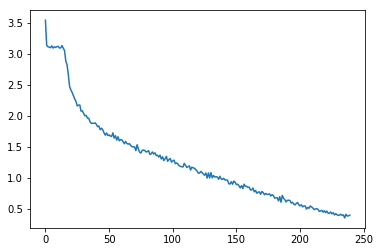

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## 5) Evaluation: Creating Potential Slogans

In [19]:
print(evaluate('Hello', 100, temperature=0.8))

Helloble quite of happiness closes, and who wish to side\nToday's Tom Sawyer\nHey just ever have a gift t


In [17]:
print(evaluate('Happiness is ', 100, temperature=0.4))

Happiness is not something and be an answer, let it be\nWhisper words of wisdom, let it be\nLet it be, let it be,


In [18]:
print(evaluate('Th', 10, temperature=1.4))

Th partical?


In [20]:
print(evaluate('Hello ', 300, temperature=1.0))

Hello who is a product of like funs\nCatch the miss which yaw it, flaplians to fade\nAnd the movement that rude share\nOh no no no I'm a rocket man\nI don't think I can do\nThere is not something oh and is a standing with life\nI used to be who world agire\n'hou, beaut, yeah, it's nothing new\nHabias aB y


In [21]:
print(evaluate('L', 300, temperature=0.6))

L' $Hp, PiLavu and going to be without you, baby tonight\nAnd in the limelility our fear\nThe underlying theme\nWhis an income as are great\nStrength does not come af drifter I could really I have leanny ontie\nMy time is the priests\nOf the Temples of it\nI'm baby that now\nI can't believe I ate the


In [22]:
print(evaluate('Love ', 20, temperature=0.9))

_!'!s Mo"iWlizina


In [ ]:
def get_evaluations(num_predictions=100, predict_len=20, temperature=0.4):
    samples = []
    
    while len(samples) != num_predictions:
        prime_str = random.choice(string.ascii_uppercase)
        samples.append(evaluate(prime_str, predict_len, temperature))
        
    return samples

## 6) Sentiment Analysis on Potential Slogans

In [ ]:
def get_sentiment(string):
    r = requests.post("http://text-processing.com/api/sentiment/", data={'text': string})
    return json.loads(r.text)

In [ ]:
def get_candidates(num_candidates=5, predict_len=20, temperature=0.8):
    candidates = []
    # Keep track of how many evaluations we calculate
    sentiment_evaluations = 0
    # Evaluate potential candidated until we have our desired amount
    while len(candidates) != num_candidates:
        prime_str = random.choice(string.ascii_uppercase)
        sample = evaluate(prime_str, predict_len, temperature)
        
        # With predicted sample, run through sentiment analysis
        sentiment = get_sentiment(sample)
        sentiment_evaluations += 1
        
        # Finalizing candidate if it has a strong enough score
        if sentiment['probability']['pos'] > 0.65:
            print(sentiment['probability'])
            candidates.append(sample)
            
        # Stop early if calculate too many evaluations (request limit)
        if sentiment_evaluations >= 1000:
            print("too many attempts: " + str(sentiment_evaluations))
            return candidates
        
    print("number of sentiment evaluations done: " + str(sentiment_evaluations))
    return candidates

In [ ]:
get_candidates()

## FINAL: Exporting the Trained Model

For use outside of this notebook, we want to save the model and make it easy to import in other files

In [16]:
torch.save(decoder.state_dict(), '../MVP/rnn_2.py')